In [ ]:
!git clone https://github.com/colome8/DAE-VAE.git

Cloning into 'DAE-VAE'...
remote: Enumerating objects: 997, done.
remote: Counting objects: 100% (997/997), done.
remote: Compressing objects: 100% (727/727), done.
remote: Total 997 (delta 273), reused 990 (delta 270), pack-reused 0 (from 0)
Receiving objects: 100% (997/997), 10.87 MiB | 34.66 MiB/s, done.
Resolving deltas: 100% (273/273), done.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## PREPROCESAMIENTO

In [ ]:
!pip install --upgrade wandb

In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
import cv2
from tensorflow import keras
from tensorflow.keras import layers, Model, Input
# Install wandb with Keras support:
import wandb
from wandb.integration.keras import WandbCallback
from wandb.integration.keras import WandbMetricsLogger
import getpass
from tensorflow.keras.callbacks import EarlyStopping

In [8]:
# Definir parámetros
IMG_SIZE = (128, 128)  # Tamaño estándar de imagen
DATASET_PATH = "/content/DAE-VAE/filtered_images"  # Ruta en Google Colab

# CLAHE (Equalización adaptativa del histograma)
def clahe_equalization(img):
    img_uint8 = (img * 255).astype(np.uint8)  # Asegurar formato correcto
    lab = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    merged = cv2.merge((cl, a, b))
    final = cv2.cvtColor(merged, cv2.COLOR_LAB2RGB)
    return final.astype(np.float32) / 255.0

# Función para cargar y preprocesar imágenes
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        try:
            img = load_img(img_path, target_size=IMG_SIZE)
            img_array = img_to_array(img) / 255.0  # Normalización (0-1)
            img_eq = clahe_equalization(img_array)  # Equalización de histograma
            images.append(img_eq)
            labels.append(label)
        except Exception as e:
            print(f"Error cargando imagen {filename}: {e}")
    return images, labels

# Cargar imágenes de ambas clases
apples_images, apples_labels = load_images_from_folder(os.path.join(DATASET_PATH, "apples"), label=0)
bananas_images, bananas_labels = load_images_from_folder(os.path.join(DATASET_PATH, "bananas"), label=1)

# Combinar datos
X = np.array(apples_images + bananas_images)
y = np.array(apples_labels + bananas_labels)

# Dividir en conjunto de entrenamiento (70%), validación (15%) y prueba (15%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Guardar datos preprocesados en formato .npz
np.savez_compressed("/content/preprocessed_dataset.npz", X_train=X_train, X_val=X_val, X_test=X_test, y_train=y_train, y_val=y_val, y_test=y_test)

print("Preprocesamiento completado. Dataset guardado como 'preprocessed_dataset.npz'")


Preprocesamiento completado. Dataset guardado como 'preprocessed_dataset.npz'


---
## DAE

In [ ]:
# 🔐 Login y setup de W&B
WANDB_API_KEY = getpass.getpass("Ingresa tu W&B API Key (oculto): ")
wandb.login(key=WANDB_API_KEY)

Ingresa tu W&B API Key (oculto): ··········


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: juan-colome (juan-colome-iteso) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
wandb.init(project="DAE-VAE",
    name="DAE-gaussian-8")

In [ ]:
def add_noise(images, noise_type="gaussian", mean=0, var=0.01, salt_prob=0.02, pepper_prob=0.02):
    noisy = []
    for img in images:
        if noise_type == "gaussian":
            row, col, ch = img.shape
            sigma = var ** 0.5
            gauss = np.random.normal(mean, sigma, (row, col, ch))
            noisy_img = img + gauss
            noisy_img = np.clip(noisy_img, 0, 1)

        elif noise_type == "salt_pepper":
            noisy_img = np.copy(img)
            total_pixels = img.shape[0] * img.shape[1]
            num_salt = int(total_pixels * salt_prob)
            coords = [np.random.randint(0, i - 1, num_salt) for i in img.shape[:2]]
            noisy_img[coords[0], coords[1], :] = 1
            num_pepper = int(total_pixels * pepper_prob)
            coords = [np.random.randint(0, i - 1, num_pepper) for i in img.shape[:2]]
            noisy_img[coords[0], coords[1], :] = 0

        else:
            noisy_img = img  # no noise
        noisy.append(noisy_img)
    return np.array(noisy)


In [ ]:
# 📦 Agregar ruido a las imágenes
X_train_noisy = add_noise(X_train, noise_type="gaussian")
X_val_noisy   = add_noise(X_val, noise_type="gaussian")
X_test_noisy  = add_noise(X_test, noise_type="gaussian")


In [ ]:
def build_autoencoder(input_shape=(128, 128, 3), latent_dim=128):
    inputs = keras.Input(shape=input_shape)

    # Encoder
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D((2, 2), padding="same")(x)
    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2, 2), padding="same")(x)
    x = layers.Flatten()(x)
    encoded = layers.Dense(latent_dim, name="latent_vector")(x)

    # Decoder
    x = layers.Dense(32 * 32 * 64, activation="relu")(encoded)
    x = layers.Reshape((32, 32, 64))(x)
    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

    autoencoder = keras.Model(inputs, decoded)
    return autoencoder

autoencoder = build_autoencoder()
autoencoder.compile(optimizer='adam', loss="binary_crossentropy")


In [ ]:
early_stop = EarlyStopping(
      monitor='val_loss',
      patience=4,  # Espera 4 epochs sin mejora
      restore_best_weights=True
    )

In [ ]:
# Asume que ya tienes: X_train, X_val, X_train_noisy, X_val_noisy
history = autoencoder.fit(
    X_train_noisy, X_train,
    validation_data=(X_val_noisy, X_val),
    epochs=30,
    batch_size=32,
    callbacks=[WandbMetricsLogger(), early_stop]
)

Epoch 1/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 290ms/step - loss: 0.6621 - val_loss: 0.5936
Epoch 2/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.5760 - val_loss: 0.5664
Epoch 3/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.5652 - val_loss: 0.5606
Epoch 4/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.5509 - val_loss: 0.5497
Epoch 5/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.5450 - val_loss: 0.5438
Epoch 6/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.5447 - val_loss: 0.5426
Epoch 7/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.5333 - val_loss: 0.5345
Epoch 8/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.5242 - val_loss: 0.5302
Epoch 9/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.5250 - val_loss: 0.5264
Epoch 10/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.5170 - val_loss: 0.5192
Epoch 11/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.5091 - val_loss: 0.5186
Epoch 12/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.

In [ ]:
autoencoder.save("dae_model.keras")
wandb.save("dae_model.keras")

['/content/wandb/run-20250324_222424-mbstnfz3/files/dae_model.keras']

In [ ]:
wandb.finish()

In [ ]:
import matplotlib.pyplot as plt

def mostrar_resultados(idx=0):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    # Imagen original
    axs[0].imshow(X_test[idx])
    axs[0].set_title("Original")
    axs[0].axis("off")

    # Imagen con ruido
    axs[1].imshow(X_test_noisy[idx])
    axs[1].set_title("Con ruido")
    axs[1].axis("off")

    # Imagen restaurada por el modelo
    restored = autoencoder.predict(X_test_noisy[idx:idx+1])[0]
    axs[2].imshow(restored)
    axs[2].set_title("Restaurada")
    axs[2].axis("off")

    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step


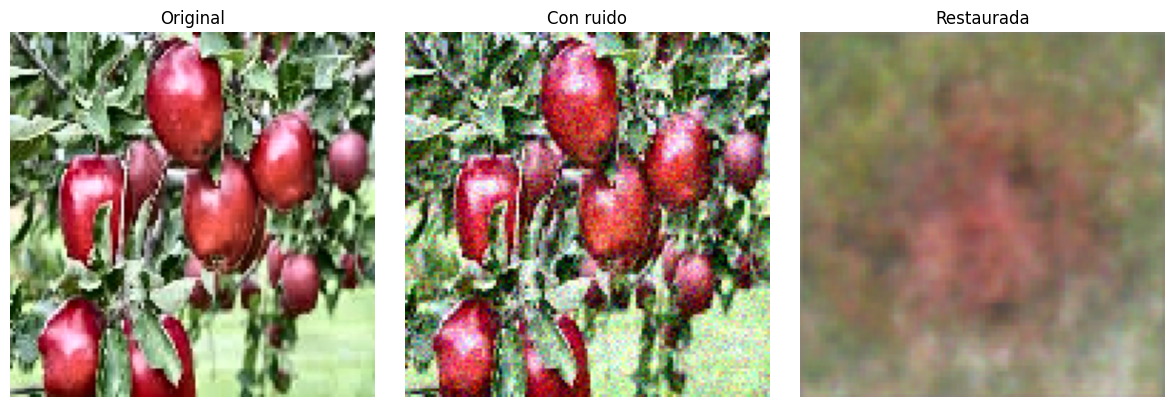

In [ ]:
mostrar_resultados(81)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


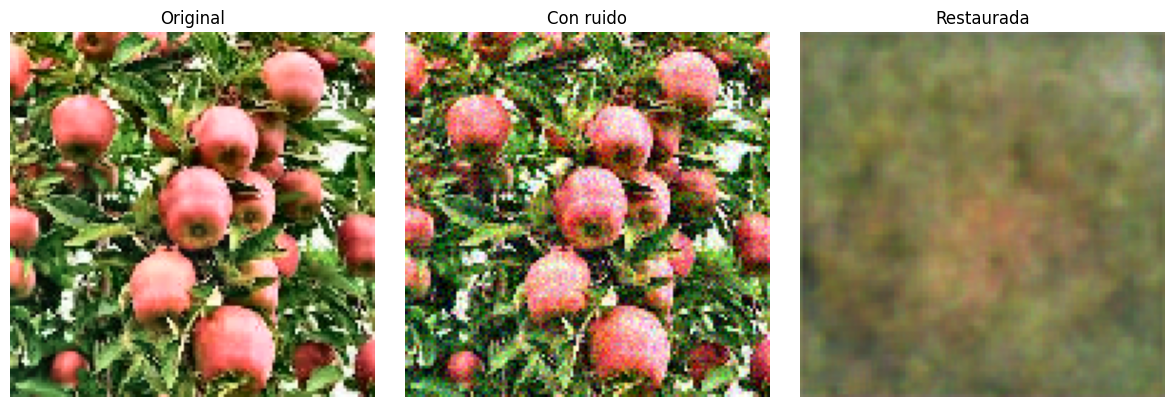

In [ ]:
mostrar_resultados(5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


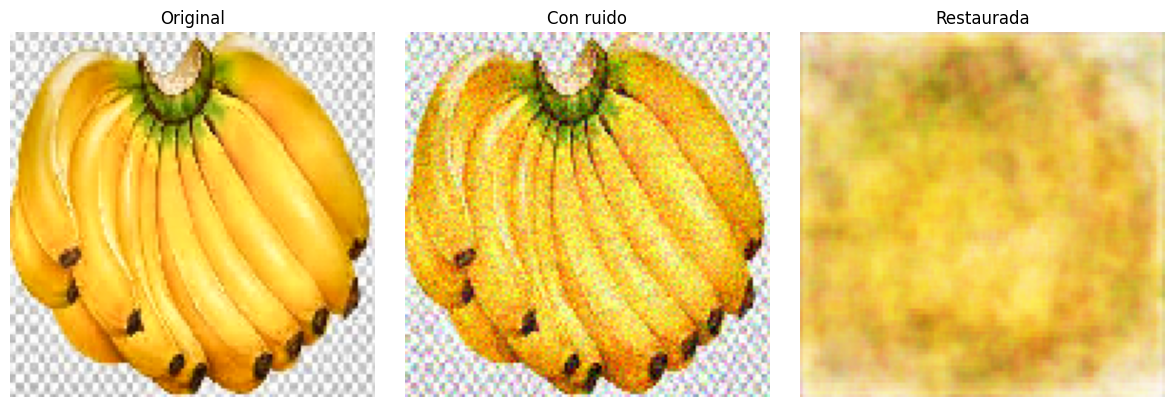

In [ ]:
mostrar_resultados(64)

In [19]:
files.download("dae_model.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

---
## VAE

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Input, Model
import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

In [4]:
# -------------------------------
# 1. Configurar W&B
# -------------------------------
WANDB_API_KEY = getpass.getpass("🔑 Ingresa tu W&B API Key (oculto): ")
wandb.login(key=WANDB_API_KEY)

🔑 Ingresa tu W&B API Key (oculto): ··········


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: juan-colome (juan-colome-iteso) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [14]:
wandb.init(project="DAE-VAE", name="VAE_6")

In [15]:
# -------------------------------
# 2. Función FID
# -------------------------------
inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

def resize_images_for_fid(images):
    images_resized = tf.image.resize(images, (299, 299))
    return preprocess_input(images_resized)

def calculate_fid(real_images, generated_images):
    real_images = tf.convert_to_tensor(real_images, dtype=tf.float32)
    generated_images = tf.convert_to_tensor(generated_images, dtype=tf.float32)
    real_images_pp = resize_images_for_fid(real_images)
    gen_images_pp = resize_images_for_fid(generated_images)
    act1 = inception_model.predict(real_images_pp, batch_size=32, verbose=0)
    act2 = inception_model.predict(gen_images_pp, batch_size=32, verbose=0)
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    ssdiff = np.sum((mu1 - mu2) ** 2)
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

# -------------------------------
# 3. Parámetros y modelo
# -------------------------------
LATENT_DIM = 256
INPUT_SHAPE = (128, 128, 3)
encoder_inputs = Input(shape=INPUT_SHAPE)
x = layers.Conv2D(32, 3, activation="relu", padding="same")(encoder_inputs)
x = layers.MaxPooling2D(2, padding="same")(x)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
x = layers.MaxPooling2D(2, padding="same")(x)
x = layers.Flatten()(x)
z_mean = layers.Dense(LATENT_DIM, name="z_mean")(x)
z_log_var = layers.Dense(LATENT_DIM, name="z_log_var")(x)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], LATENT_DIM))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling, name="z")([z_mean, z_log_var])
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

latent_inputs = Input(shape=(LATENT_DIM,))
x = layers.Dense(32 * 32 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((32, 32, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
x = layers.UpSampling2D(2)(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", padding="same")(x)
x = layers.UpSampling2D(2)(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder = Model(latent_inputs, decoder_outputs, name="decoder")

# -------------------------------
# 4. Definición del VAE
# -------------------------------
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def compile(self, optimizer, **kwargs):
        super(VAE, self).compile(loss=lambda y_true, y_pred: 0, optimizer=optimizer, **kwargs)
        self.optimizer = optimizer
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(
                keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)))
            kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result()
        }

    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)

        reconstruction_loss = tf.reduce_mean(tf.reduce_sum(
            keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)))
        kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(
            1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1))
        total_loss = reconstruction_loss + kl_loss

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "val_loss": self.total_loss_tracker.result(),
            "val_reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "val_kl_loss": self.kl_loss_tracker.result()
        }

    def call(self, inputs, training=None, mask=None):
        _, _, z = self.encoder(inputs)
        return self.decoder(z)

# -------------------------------
# 5. Callback para imágenes y FID
# -------------------------------
class ImageLoggerCallback(keras.callbacks.Callback):
    def __init__(self, decoder, latent_dim, real_images):
        self.decoder = decoder
        self.latent_dim = latent_dim
        self.real_images = real_images

    def on_epoch_end(self, epoch, logs=None):
        z_sample = tf.random.normal(shape=(100, self.latent_dim))
        generated = self.decoder.predict(z_sample)
        fid = calculate_fid(self.real_images[:100], generated[:100])
        wandb.log({
            "sampled_image": wandb.Image(generated[0], caption=f"Epoch {epoch + 1}"),
            "FID": fid
        })

# -------------------------------
# 6. Preparar y compilar VAE
# -------------------------------
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# -------------------------------
# 7. Entrenamiento
# -------------------------------
early_stop = EarlyStopping(
    monitor='val_reconstruction_loss',
    patience=3,
    restore_best_weights=True,
    mode='min'
)

vae.fit(
    X_train, X_train,
    validation_data=(X_val, X_val),
    epochs=30,
    batch_size=32,
    callbacks=[
        WandbMetricsLogger(),
        ImageLoggerCallback(decoder=decoder, latent_dim=LATENT_DIM, real_images=X_test),
        early_stop
    ]
)

# -------------------------------
# 8. Guardar modelos
# -------------------------------
encoder.save("vae_encoder.keras")
decoder.save("vae_decoder.keras")
print("✅ ¡Entrenamiento finalizado y modelos guardados!")


Epoch 1/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


14/14 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - kl_loss: 438.0923 - loss: 11253.8232 - reconstruction_loss: 10815.7305 - val_val_kl_loss: 41.3401 - val_val_loss: 10035.6211 - val_val_reconstruction_loss: 9994.2803
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 49s 929ms/step - kl_loss: 44.1586 - loss: 9805.6357 - reconstruction_loss: 9761.4775 - val_val_kl_loss: 44.1805 - val_val_loss: 9505.8262 - val_val_reconstruction_loss: 9461.6455
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 21s 945ms/step - kl_loss: 39.6211 - loss: 9614.6855 - reconstruction_loss: 9575.0654 - val_val_kl_loss: 29.8977 - val_val_loss: 9298.4229 - val_val_reconstruction_loss: 9268.5254
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 840ms/step - kl_loss: 34.2565 - loss: 9110.9834 - reconstruction_loss: 9076.7266 - val_val_kl_loss: 40.0200 - val_val_loss: 9178.8525 - val_val_reconstruction_loss: 9138.8320
Epoch 5/30
4/4 ━━━━━━━━━━━━━

In [16]:
wandb.finish()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


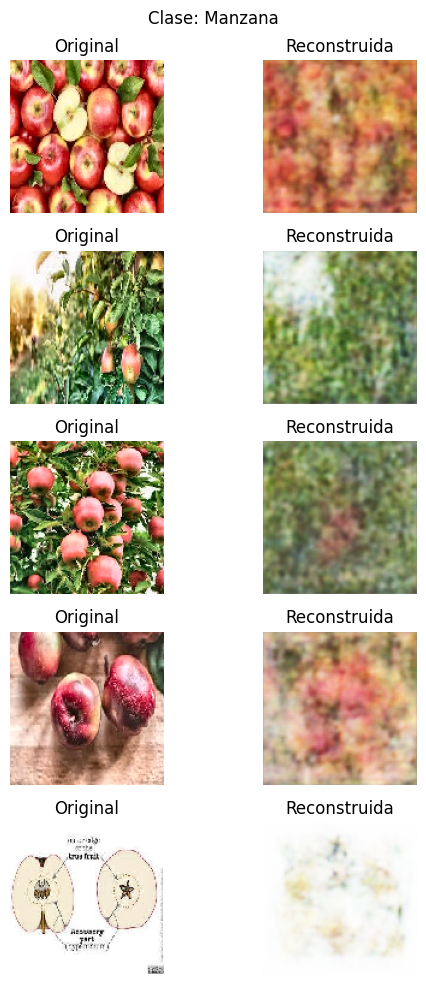

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


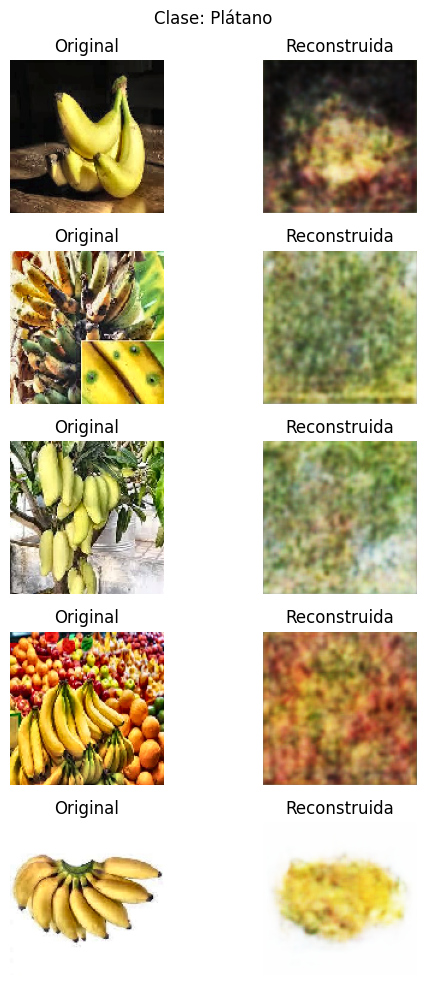

In [17]:
import matplotlib.pyplot as plt

def mostrar_imagenes_por_clase(vae, X, y, clase=0, cantidad=5):
    indices = np.where(y == clase)[0][:cantidad]
    imagenes = X[indices]
    reconstrucciones = vae.predict(imagenes)

    fig, axs = plt.subplots(cantidad, 2, figsize=(6, cantidad * 2))

    for i in range(cantidad):
        axs[i, 0].imshow(imagenes[i])
        axs[i, 0].set_title("Original")
        axs[i, 0].axis("off")

        axs[i, 1].imshow(reconstrucciones[i])
        axs[i, 1].set_title("Reconstruida")
        axs[i, 1].axis("off")

    plt.suptitle(f"Clase: {'Manzana' if clase == 0 else 'Plátano'}")
    plt.tight_layout()
    plt.show()

# Mostrar 5 de cada clase
mostrar_imagenes_por_clase(vae, X_test, y_test, clase=0, cantidad=5)
mostrar_imagenes_por_clase(vae, X_test, y_test, clase=1, cantidad=5)


In [18]:
from google.colab import files

# Descargar los archivos
files.download("vae_encoder.keras")
files.download("vae_decoder.keras")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

---
## GIT ACTIONS CON GOOGLE COLAB

In [ ]:
!git config --global user.email "colomeab84@gmail.com"
!git config --global user.name "colome8"

In [ ]:
%cd /content/DAE-VAE
!git add trabajo_clonado.ipynb
!git commit -m "Modelos terminados"
!git push origin main

/content/DAE-VAE
On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
fatal: could not read Username for 'https://github.com': No such device or address
